In [1]:
import sys
from pathlib import Path

# Add src/ to path (notebook is in src/agents/project_manager/)
src_path = Path().resolve().parent.parent  # Goes up 2 levels from project_manager
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))
    
    
from langgraph.graph import StateGraph, END
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage, AnyMessage
from models import call_llm
from rag.retriever import retrieve, format_retrieved_documents

# Import ALL_API_TOOLS - Real backend API calls
from api_tools import ALL_API_TOOLS

import json
from typing import TypedDict, Annotated, Literal, List
from pydantic import BaseModel, Field
from typing import Literal
import operator

# Router


In [2]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    query: str
    router_decision: str # "RAG" or "DIRECT"
    grader_decision: str # "QUERY_REWRITER" or "ANSWER"
    retrieved_documents: list[dict]
    grader_critique: str
    feedback_history: Annotated[List[str], operator.add]
    # maximun rewrite turns
    rewrite_numbers: int
    max_rewrite: int

In [3]:
# Schema outputs
class RouterOutput(BaseModel):
    """Schema for Router"""
    decision: Literal["RAG", "TOOL_CALL", "DIRECT"] = Field(
        description="Quyết định phân luồng: 'RAG' cho truy vấn cần tra cứu tài liệu nội bộ, 'DIRECT' cho hội thoại/trả lời trực tiếp không cần tra cứu tài liệu."
    )

class GraderOuput(BaseModel):
    """Schema for Grader"""
    decision: Literal['QUERY_REWRITER', 'ANSWER'] = Field(
        description="Quyết định của bộ phân tích: 'ANSWER' nếu tài liệu truy xuất đủ để trả lời, 'QUERY_REWRITER' nếu cần viết lại truy vấn để tìm tài liệu phù hợp hơn."
    )
    critique: str = Field(
        description="Lời nhận xét ngắn gọn bằng tiếng Việt, giải thích lý do của quyết định và (nếu có) gợi ý cải thiện truy vấn."
    )

In [4]:
param_dict = {
    'router_kwargs': {
        'model_provider': 'gemini',
        'model_name': 'gemini-2.5-flash-lite-preview-09-2025',
        'temperature': 0.3,
        'top_p': 0.7,
    },
    'direct_kwargs': {
        'model_provider': 'gemini',
        'model_name': 'gemini-2.0-flash-lite',
        'temperature': 0.5,
        'top_p': 0.9,
        'max_tokens': 200,
    },
    'large_deterministic_kwargs': { # grader, rag, tool_call
        'model_provider': 'gemini',
        'model_name': 'gemini-2.5-flash',
        'temperature': 0.3,
        'top_p': 0.7,
    },
    'rewriter_kwargs': {
        'model_provider': 'gemini',
        'model_name': 'gemini-2.5-flash-lite-preview-09-2025',
        'temperature': 0.3,
        'top_p': 0.7,
        'max_tokens': 100,
    },
}


In [12]:
class AgenticRAG:
    def __init__(self, current_user_id: int):
        """
        Initialize the Agentic RAG system.
        
        Args:
            current_user_id: ID của user hiện tại (int) - chỉ được truy cập dữ liệu của user này
        """
        self.current_user_id = current_user_id
        
        self.llm_router = call_llm(**param_dict['router_kwargs'])
        self.llm_rag = call_llm(**param_dict['large_deterministic_kwargs'])
        self.llm_direct = call_llm(**param_dict['direct_kwargs'])
        self.llm_tool_call = call_llm(**param_dict['large_deterministic_kwargs'])
        self.llm_grader = call_llm(**param_dict['large_deterministic_kwargs'])
        self.llm_rewriter = call_llm(**param_dict['rewriter_kwargs'])
        
        # Use ALL_API_TOOLS - real backend API calls (4 tools: search, get_user_tasks, create_task, update_task_status)
        self.tools_list = ALL_API_TOOLS
        self.tools = {t.name: t for t in self.tools_list}
        self.llm_tool_call = self.llm_tool_call.bind_tools(self.tools_list)
        
        self.graph = self.build_graph()
    
    def build_graph(self) -> StateGraph:
        builder = StateGraph(AgentState)
        
        # Intent classifier
        builder.add_node('router', self.router)
        
        # RAG nodes
        builder.add_node('retriever', self.retriever)
        builder.add_node('grader', self.grader)
        builder.add_node('query_rewriter', self.query_rewriter)
        builder.add_node('rag_generator', self.rag_generator)

        # Tool Call nodes
        builder.add_node('tool_call', self.take_action)
        builder.add_node('tool_generator', self.tool_generator)

        # DIRECT nodes
        builder.add_node('direct_generator', self.direct_generator)
        
        builder.set_entry_point('router')
        # Edges
        builder.add_conditional_edges(
            'router',
            self._intent_classify,
            {
                'RAG': 'retriever',
                'TOOL_CALL': 'tool_generator',
                'DIRECT': 'direct_generator'
            }
        )
        # RAG route
        builder.add_edge('retriever', 'grader')
        builder.add_conditional_edges(
            'grader',
            self._exist_rewrite,
            {
                True: 'query_rewriter',
                False: 'rag_generator'
            }
        )
        builder.add_edge('query_rewriter', 'retriever')
        builder.add_edge('rag_generator', END)
        # Tool Call route
        builder.add_conditional_edges(
            'tool_generator',
            self._exist_tool,
            {
                True: 'tool_call',
                False: END
            }
        )
        builder.add_edge('tool_call', 'tool_generator')
        # DIRECT route
        builder.add_edge('direct_generator', END)
        
        return builder.compile()
    
    
    # Router node
    def router(self, state: AgentState):
        """Router node to decide between RAG and Direct generation"""
        
        query = state['query']
        prompt = """Phân loại câu hỏi vào 1 trong 3 nhánh:

DIRECT - Trả lời trực tiếp:
• Chào hỏi, cảm ơn, small talk
• Viết email, dịch thuật, soạn văn bản
• Kiến thức chung (Agile, Scrum, REST API...)

RAG - Tra cứu tài liệu nội bộ:
• Quy trình, quy định, SOP công ty
• Vai trò, trách nhiệm, RACI nội bộ
• Change request, escalation, xử lý sự cố
• Câu hỏi về phí, thanh toán, chi phí dự án

TOOL_CALL - Thao tác dữ liệu cá nhân:
• Xem/tạo/cập nhật task CỦA TÔI
• Tìm kiếm task/project của tôi

VÍ DỤ:
• "Viết email xin hoãn deadline" → DIRECT
• "Quy trình xin hoãn deadline" → RAG  
• "Tasks của tôi" → TOOL_CALL
• "Khách đổi ý thì tính thêm tiền không?" → RAG"""

        messages = [
            SystemMessage(content=prompt),
            HumanMessage(content=query)
        ]
        
        response = self.llm_router.with_structured_output(RouterOutput, method="function_calling").invoke(messages)
        
        print(f"Router decision: {response.decision}")
        print("-" * 80)
        
        return {'router_decision': response.decision}
    
    # Tool nodes
    def tool_generator(self, state: AgentState) -> None:
        """Generate tool calls if necessary"""
        
        messages = state['messages']
        query = state['query']
        
        tool_prompt = f"""PM Assistant - Quản lý công việc của user_id={self.current_user_id}

TOOLS:
1. get_user_tasks(user_id={self.current_user_id}) - Xem tasks của tôi
2. search(query) - Tìm kiếm tasks/projects
3. create_task(title, project_id, author_user_id={self.current_user_id}, ...) - Tạo task
4. update_task_status(task_id, status) - Cập nhật status (To Do/In Progress/Done)

RULES:
• Luôn dùng user_id={self.current_user_id} cho get_user_tasks
• Luôn set author_user_id={self.current_user_id} khi tạo task
• Từ chối nếu hỏi về tasks của người khác
• Trả lời bằng tiếng Việt"""

        if not messages:
            messages = [
                SystemMessage(content=tool_prompt),
                HumanMessage(content=query)
            ]
        else:
            messages = [
                SystemMessage(content=tool_prompt),
                HumanMessage(content=query),
                *messages
            ]
        response = self.llm_tool_call.invoke(messages)
        # Handle both string and list content formats
        if isinstance(response.content, list):
            # Extract text from list format (Gemini format)
            display_content = response.content[0].get('text', '') if response.content else ''
        else:
            display_content = response.content
        print(f"Tool generator response: {display_content}")
        print("-" * 80)
        
        return {'messages': [response]}
    
    def take_action(self, state: AgentState) -> None:
        last_message = state['messages'][-1]
        
        if not last_message or not hasattr(last_message, 'tool_calls'):
            return {'messages': []}    
            
        tool_messages = []
        for tool_call in last_message.tool_calls:
            tool_name = tool_call['name']
            tool_args = tool_call['args']
            tool_id = tool_call['id']
            
            print(f"Executing: {tool_name}")
            print(f"Args: {tool_args}")
            
            # === SCOPE ENFORCEMENT ===
            # Chỉ cho phép truy cập dữ liệu của current user
            
            # 1. Force user_id cho get_user_tasks
            if tool_name == 'get_user_tasks':
                tool_args['user_id'] = self.current_user_id
                print(f"[SCOPE] Forced user_id = {self.current_user_id}")
            
            # 2. Force author_user_id cho create_task
            if tool_name == 'create_task':
                tool_args['author_user_id'] = self.current_user_id
                print(f"[SCOPE] Forced author_user_id = {self.current_user_id}")
            
            # Execute tool
            if tool_name in self.tools:
                try:
                    result = self.tools[tool_name].invoke(tool_args)
                    print(f"Success: {result}")
                    
                    tool_messages.append(ToolMessage(
                        content=json.dumps(result, ensure_ascii=False, default=str),
                        tool_call_id=tool_id
                    ))
                    
                except Exception as e:
                    print(f"Error: {str(e)}")
                    tool_messages.append(ToolMessage(
                        content=f"Error: {str(e)}",
                        tool_call_id=tool_id
                    ))
            else:
                tool_messages.append(ToolMessage(
                    content=f"Unknown tool: {tool_name}",
                    tool_call_id=tool_id
                ))
                    
        print('-' * 80)
        return {'messages': tool_messages}
        
    # RAG Nodes
    def retriever(self, state: AgentState) -> None:
        """Retrieve documents"""
        
        query = state['query']
        retrieved_documents = retrieve(query=query, collection_name='ProjectDocuments', use_reranker=True, top_k=3)
        
        print(f"Retrieved {len(retrieved_documents.objects)} documents.")
        
        formatted_retrieved_documents = format_retrieved_documents(retrieved_documents)
        
        print(f"Retrieved docments: {formatted_retrieved_documents}")
        print("-" * 80) 
        
        return {'retrieved_documents': formatted_retrieved_documents}
        
    def grader(self, state: AgentState):
        """ Grade retrieved documents based on criteria with History Tracking """
        
        # Lấy dữ liệu từ State
        query = state['query']
        retrieved_docs = state['retrieved_documents']
    
        grader_prompt = """Đánh giá tài liệu có ĐỦ thông tin trả lời câu hỏi không.

CRITERIA ĐÁNH GIÁ (cho điểm 0-2 mỗi tiêu chí):

1. RELEVANCE - Tài liệu có liên quan đến chủ đề câu hỏi?
   0: Không liên quan | 1: Liên quan một phần | 2: Trực tiếp liên quan

2. COMPLETENESS - Thông tin có đầy đủ để trả lời?
   0: Thiếu hoàn toàn | 1: Có nhưng thiếu chi tiết | 2: Đầy đủ

3. SPECIFICITY - Có quy trình/bước cụ thể hay chỉ chung chung?
   0: Quá chung | 1: Có hướng dẫn nhưng chưa rõ | 2: Có bước cụ thể

QUYẾT ĐỊNH:
• ANSWER: Tổng điểm ≥ 4 VÀ không có tiêu chí nào = 0
• QUERY_REWRITER: Tổng điểm < 4 HOẶC có tiêu chí = 0

OUTPUT (tiếng Việt):
• Nêu điểm từng tiêu chí: R=?/C=?/S=? (Total=?)
• Nếu QUERY_REWRITER: Gợi ý từ khóa/thuật ngữ thay thế"""

        user_prompt = f"""Câu hỏi: "{query}"

Tài liệu:
{retrieved_docs}"""
        
        messages = [
            SystemMessage(content=grader_prompt),
            HumanMessage(content=user_prompt)
        ]
        
        # Gọi LLM
        result = self.llm_grader.with_structured_output(GraderOuput).invoke(messages)
        
        # Logging
        print(f"Grader decision: {result.decision}")
        print(f"Grader critique: {result.critique}")
        print("-" * 80) 
        
        
        # Tạo message feedback có chứa cả Query đã dùng và Lý do thất bại
        feedback_entry = f"Query đã thử: '{query}'. Phản hồi: {result.critique}"
        
        return {
            'grader_decision': result.decision,
            'feedback_history': [feedback_entry] 
        }
        
    def query_rewriter(self, state: AgentState) -> None:
        """ Rewrite the query based on critique and original query"""
        
        query = state['query']
        
        # Lấy lịch sử feedback (nếu có), nối lại thành chuỗi văn bản để đưa vào Prompt
        feedback_history = state.get('feedback_history', [])
        history_str = "\n".join(feedback_history) if feedback_history else "Chưa có lịch sử."

        rewriter_prompt = """Viết lại truy vấn tìm kiếm tối ưu hơn.

NGUYÊN TẮC:
• Tránh lặp từ khóa đã thất bại
• Chuyển ngôn ngữ tự nhiên → thuật ngữ chuyên ngành
• Giữ nguyên ý định câu hỏi gốc

OUTPUT: Chỉ trả về câu truy vấn mới, không giải thích."""
        
        user_prompt = f"""Truy vấn thất bại: "{query}"
Lịch sử chỉnh sửa: {history_str}"""
        
        messages = [
            SystemMessage(content=rewriter_prompt),
            HumanMessage(content=user_prompt),
        ]
        
        # 4. Gọi LLM
        response = self.llm_rewriter.invoke(messages)
        new_query = response.content.strip()

        print(f"Rewritten query: {new_query}")
        print("-" * 80)
        
        return {
            'query': new_query,
            'rewrite_numbers': state.get('rewrite_numbers', 0) + 1
        }

    def rag_generator(self, state: AgentState) -> None:
        """Generator aggregates retrieved document"""
        
        query = state['query']
        retrieved_documents = state['retrieved_documents']
        messages = state['messages']
        rag_generator_prompt = """Trả lời dựa trên tài liệu được cung cấp.
• Nếu không tìm thấy: nói rõ "Không tìm thấy trong tài liệu"
• Trả lời ngắn gọn, súc tích
• Không suy diễn ngoài tài liệu"""

        user_prompt = f"""Tài liệu:
{retrieved_documents}

Câu hỏi: {query}"""

        messages = [
            SystemMessage(content=rag_generator_prompt),
            *messages,
            HumanMessage(content=user_prompt)

        ]
        response = self.llm_rag.invoke(messages)

        print(f"RAG generator response: {response.content}")
        print("-" * 80)
        
        return {'messages': [response]}
    
    # Direct answer node
    def direct_generator(self, state: AgentState) -> None:
        """Generate direct answer non-related RAG queries"""
        
        messages = state['messages']
        query = state['query']
        system_prompt = """Trợ lý AI thân thiện. Trả lời tự nhiên, ngắn gọn.
Không tự ý cung cấp thông tin về dự án, task hay nghiệp vụ nội bộ."""

        messages = [
            SystemMessage(content=system_prompt),
            *messages,
            HumanMessage(content=query)
        ]
        
        response = self.llm_direct.invoke(messages)
        
        print(f"Direct generator response: {response.content}")
        print("-" * 80)
        
        return {"messages": [response]}
        
    # Conditions
    def _intent_classify(self, state: AgentState):
        return state['router_decision']
    
    def _exist_rewrite(self, state: AgentState) -> bool:
        if state['rewrite_numbers'] > state['max_rewrite']:
            return False
        return state['grader_decision'] == 'QUERY_REWRITER'

    def _exist_tool(self, state: AgentState) -> bool:
        messages = state.get('messages', [])
        if not messages:
            return False
        
        last_message = messages[-1]
        tool_calls = getattr(last_message, 'tool_calls', None)
        return bool(tool_calls)
        
    def get_graph(self):
        """Hiển thị graph dưới dạng hình ảnh"""
        from IPython.display import Image, display
        
        img = self.graph.get_graph().draw_mermaid_png()
        return display(Image(img))

In [6]:
# Exact(code-based) Evaluation
def test_router():
    # Initialize the agent with user_id only (no project_id - user-scoped)
    agent = AgenticRAG(current_user_id=1)
    
    # Test cases for all 3 routes
    test_queries = [
        # Should route to DIRECT
        ("Xin chào!", "DIRECT"),
        ("Agile/Scrum là gì?", "DIRECT"),
        ("Viết email xin nghỉ phép", "DIRECT"),
        ("REST API là gì?", "DIRECT"),
        
        # Should route to RAG
        ("Quy trình xin nghỉ phép của công ty là gì?", "RAG"),
        ("PM cần làm gì trong giai đoạn Khởi tạo dự án?", "RAG"),
        ("Ai chịu trách nhiệm review code?", "RAG"),
        ("Quy trình xử lý change request như thế nào?", "RAG"),
        
        # Should route to TOOL_CALL - CHỈ tasks của tôi
        ("Tasks của tôi", "TOOL_CALL"),
        ("Cập nhật task #123 sang trạng thái In Progress", "TOOL_CALL"),
        ("Tạo task mới Review code", "TOOL_CALL"),
        ("Tôi đang làm những gì?", "TOOL_CALL"),
        
        # Edge cases - ngôn ngữ tự nhiên nhưng là RAG
        ("Khách đổi ý giữa chừng thì tính thêm tiền không?", "RAG"),
        ("Scope creep thì xử lý sao?", "RAG"),
        ("Khách muốn thêm tính năng giữa sprint thì làm gì?", "RAG"),
        ("Ai duyệt CR?", "RAG"),
    ]
    
    print("Testing Router Node")
    print("=" * 60)
    
    results = {"DIRECT": [], "RAG": [], "TOOL_CALL": []}
    
    for query, expected in test_queries:
        # Create initial state
        state: AgentState = {
            "messages": [],
            "query": query,
            "retrieved_documents": [],
            "grader_critique": "",
            "rewrite_numbers": 0,
            "max_rewrite": 3,
            "router_decision": "",
            "grader_decision": "",
            "feedback_history": [],
        }
        
        # Call router node
        result = agent.router(state)
        actual = result['router_decision']
        
        # Check result
        is_correct = actual == expected
        status = "✓" if is_correct else "✗"
        results[expected].append(is_correct)
        
        print(f"{status} Query: '{query}'")
        print(f"  Expected: {expected}, Got: {actual}")
        print()
    
    # Summary
    print("=" * 60)
    print("SUMMARY:")
    total_correct = 0
    total_tests = 0
    for route, route_results in results.items():
        correct = sum(route_results)
        total = len(route_results)
        total_correct += correct
        total_tests += total
        print(f"  {route}: {correct}/{total} ({100*correct/total:.1f}%)")
    
    print(f"\n  TOTAL: {total_correct}/{total_tests} ({100*total_correct/total_tests:.1f}%)")
    print("=" * 60)
    
    return total_correct == total_tests

# Run test
test_router()

Testing Router Node
Router decision: DIRECT
--------------------------------------------------------------------------------
✓ Query: 'Xin chào!'
  Expected: DIRECT, Got: DIRECT

Router decision: DIRECT
--------------------------------------------------------------------------------
✓ Query: 'Xin chào!'
  Expected: DIRECT, Got: DIRECT

Router decision: DIRECT
--------------------------------------------------------------------------------
✓ Query: 'Agile/Scrum là gì?'
  Expected: DIRECT, Got: DIRECT

Router decision: DIRECT
--------------------------------------------------------------------------------
✓ Query: 'Agile/Scrum là gì?'
  Expected: DIRECT, Got: DIRECT

Router decision: DIRECT
--------------------------------------------------------------------------------
✓ Query: 'Viết email xin nghỉ phép'
  Expected: DIRECT, Got: DIRECT

Router decision: DIRECT
--------------------------------------------------------------------------------
✓ Query: 'Viết email xin nghỉ phép'
  Expected:

True

# Metadata generation (optional)

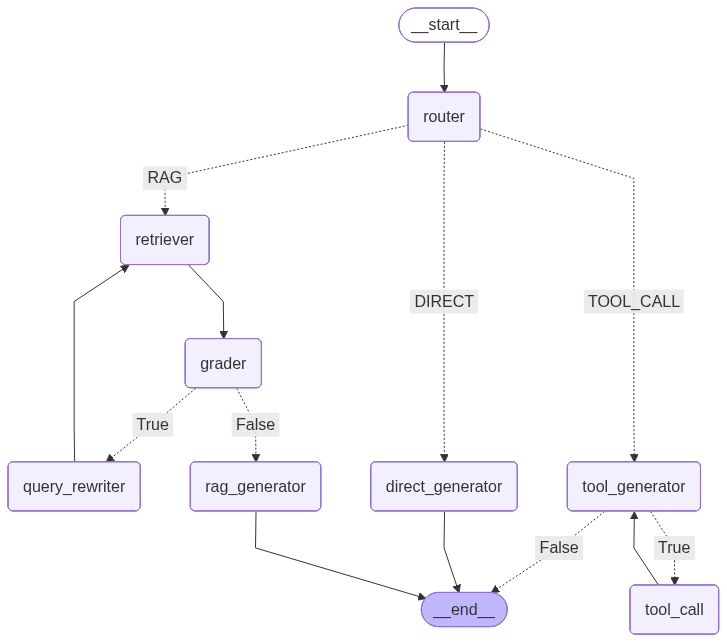

In [ ]:
# Initialize agent with user_id only (user-scoped)
agent = AgenticRAG(current_user_id=1)
agent.get_graph()

# Test cases


In [7]:
direct_query = "Agile/Scrum là gì và khác gì Waterfall?"

rag_query = "PM cần làm gì trong giai đoạn Khởi tạo dự án?"

rewriter_query = "Khách muốn thêm tính năng giữa sprint thì làm gì?"

# Updated tool call queries - User-scoped (4 tools only)
tool_call_query = "Tạo task mới với tiêu đề 'Review code module authentication', priority High"

search_query = "Tìm các task liên quan đến authentication"

my_tasks_query = "Tasks của tôi"

update_status_query = "Cập nhật task #5 sang trạng thái Done"

In [13]:
# RAG case
agent = AgenticRAG(current_user_id=1)
initial_state: AgentState = {
    "messages": [],
    "query": rag_query,
    "retrieved_documents": [],
    "grader_critique": "",
    "feedback_history": [], 
    "rewrite_numbers": 1,
    "max_rewrite": 2,
    "router_decision": "",
    "grader_decision": "",
}
final_state = agent.graph.invoke(initial_state)

Router decision: RAG
--------------------------------------------------------------------------------
Retrieved 3 documents.
Retrieved docments: [Document 1]
title: Nghiệp vụ quản lí project
page: 3
creationdate: 
author: 
content: ●  Dự  án  được  chia  thành  các  Sprint  (thường  2  tuần/sprint).  ●  Sprint  Planning:  Đầu  mỗi  Sprint,  team  thống  nhất  danh  sách  Task  sẽ  làm.  ●  Daily  Standup:  Họp  nhanh  15p  mỗi  sáng  để  cập  nhật  tiến  độ  (Hôm  qua  làm  gì?  Hôm  nay  
làm
 
gì?
 
Có
 
gặp
 
khó
 
khăn
 
gì
 
không?).
 ●  Coding  &  Unit  Test:  Dev  thực  hiện  code  và  tự  kiểm  tra  mức  đơn  vị.  
Giai  đoạn  4:  Kiểm  soát  &  Đảm  bảo  chất  lượng  (Monitor  &  Control)
source: documents\document.pdf

[Document 2]
title: Nghiệp vụ quản lí project
page: 2
creationdate: 
author: 
content: Quy  trình  chuẩn  bao  gồm  05  giai  đoạn:  
Giai  đoạn  1:  Khởi  tạo  (Initiation)  
●  Đầu  vào:  Hợp  đồng  đã  ký  hoặc  Yêu  cầu  sơ  bộ  (Brief).  ●  Hành  động:
sou

In [14]:
# Rewriter case
initial_state: AgentState = {
    "messages": [],
    "query": rewriter_query,
    "retrieved_documents": [],
    "grader_critique": "",
    "feedback_history": [], 
    "rewrite_numbers": 1,
    "max_rewrite": 2,
    "router_decision": "",
    "grader_decision": "",
}
final_state = agent.graph.invoke(initial_state)

Router decision: RAG
--------------------------------------------------------------------------------
Retrieved 3 documents.
Retrieved docments: [Document 1]
title: Nghiệp vụ quản lí project
page: 3
creationdate: 
author: 
content: ●  Dự  án  được  chia  thành  các  Sprint  (thường  2  tuần/sprint).  ●  Sprint  Planning:  Đầu  mỗi  Sprint,  team  thống  nhất  danh  sách  Task  sẽ  làm.  ●  Daily  Standup:  Họp  nhanh  15p  mỗi  sáng  để  cập  nhật  tiến  độ  (Hôm  qua  làm  gì?  Hôm  nay  
làm
 
gì?
 
Có
 
gặp
 
khó
 
khăn
 
gì
 
không?).
 ●  Coding  &  Unit  Test:  Dev  thực  hiện  code  và  tự  kiểm  tra  mức  đơn  vị.  
Giai  đoạn  4:  Kiểm  soát  &  Đảm  bảo  chất  lượng  (Monitor  &  Control)
source: documents\document.pdf

[Document 2]
title: Nghiệp vụ quản lí project
page: 3
creationdate: 
author: 
content: ●  QC  Testing:  Sau  khi  Dev  hoàn  thành  task,  QC  sẽ  test  trên  môi  trường  Staging.  ●  Bug  Fixing:  Dev  sửa  lỗi  do  QC  log.  ●  Demo:  Cuối  Sprint,  team  de

In [ ]:
# File: server/AI/src/agents/project_manager/agent.py

class ProjectManagerAgent:
    def __init__(self):
        print("🤖 Project Manager Agent đã khởi động!")

    def run(self, message: str, project_id: str = None, user_id: str = None, thread_id: str = "general"):
        """
        Hàm nhận tin nhắn và trả lời
        """
        print(f"User {user_id} hỏi: {message}")
        
        # Logic trả lời đơn giản (Mock)
        if "hello" in message.lower() or "chào" in message.lower():
            return "Chào bạn! Tôi là trợ lý ảo Project Manager. Tôi có thể giúp gì cho dự án của bạn?"
        
        if "task" in message.lower():
            return "Bạn muốn tạo task mới hay kiểm tra tiến độ các task hiện tại?"

        return f"Tôi đã nhận được câu hỏi: '{message}'. Hiện tại tôi đang học việc nên chỉ trả lời được thế này thôi!"

In [ ]:
# Tool Call case - Create Task (user-scoped)
agent = AgenticRAG(current_user_id=1)
initial_state: AgentState = {
    "messages": [],
    "query": tool_call_query,
    "retrieved_documents": [],
    "grader_critique": "",
    "feedback_history": [], 
    "rewrite_numbers": 1,
    "max_rewrite": 2,
    "router_decision": "",
    "grader_decision": "",
}
final_state = agent.graph.invoke(initial_state)

Router decision: TOOL_CALL
--------------------------------------------------------------------------------
Tool generator response: 
--------------------------------------------------------------------------------
Executing: create_task
Args: {'title': 'Review code module authentication', 'assigned_username': 'bob', 'priority_name': 'High'}
Success: {'success': True, 'message': 'Task #140 đã được tạo thành công', 'task': {'id': 140, 'title': 'Review code module authentication', 'description': '', 'statusId': 1, 'priorityId': 3, 'assignedUserId': 5, 'authorUserId': 1, 'projectId': 1, 'dueDate': None, 'created_at': '2025-12-02T17:28:45.864834', 'assignee_name': 'bob', 'priority_name': 'High', 'status_name': 'To Do'}}
--------------------------------------------------------------------------------
Tool generator response: Task "Review code module authentication" với độ ưu tiên High đã được tạo thành công cho bob. Task có ID là #140 và hiện đang ở trạng thái "To Do".
---------------------

In [ ]:
# Tool Call case - Search (user-scoped)
agent = AgenticRAG(current_user_id=1)
initial_state: AgentState = {
    "messages": [],
    "query": search_query,
    "retrieved_documents": [],
    "grader_critique": "",
    "feedback_history": [], 
    "rewrite_numbers": 1,
    "max_rewrite": 2,
    "router_decision": "",
    "grader_decision": "",
}
final_state = agent.graph.invoke(initial_state)

Router decision: TOOL_CALL
--------------------------------------------------------------------------------
Tool generator response: Bạn muốn tạo task 'Fix bug login'. Task này sẽ được giao cho ai vậy bạn?
--------------------------------------------------------------------------------


In [15]:
# Direct case
initial_state: AgentState = {
    "messages": [],
    "query": direct_query,
    "retrieved_documents": [],
    "grader_critique": "",
    "feedback_history": [], 
    "rewrite_numbers": 1,
    "max_rewrite": 2,
    "router_decision": "",
    "grader_decision": "",
}
final_state = agent.graph.invoke(initial_state)

Router decision: DIRECT
--------------------------------------------------------------------------------
Direct generator response: Agile và Scrum là các phương pháp quản lý dự án linh hoạt, tập trung vào sự hợp tác, thích ứng nhanh với thay đổi và giao sản phẩm theo chu kỳ ngắn (Sprint).

Waterfall là phương pháp quản lý dự án truyền thống, tuân theo quy trình tuyến tính, đi từ giai đoạn này đến giai đoạn khác một cách tuần tự.

**Khác biệt chính:**

*   **Tính linh hoạt:** Agile linh hoạt hơn, dễ dàng thay đổi yêu cầu. Waterfall ít linh hoạt, khó thay đổi khi dự án đã bắt đầu.
*   **Phản hồi:** Agile chú trọng vào việc nhận phản hồi liên tục từ khách hàng. Waterfall ít chú trọng vào phản hồi trong quá trình.
*   **Thời gian:** Agile thường có chu kỳ phát triển ngắn (Sprint). Waterfall có các giai đoạn dài hơn.
*   **Sản phẩm:** Agile tập trung vào việc giao sản phẩm sớm và liên tục. Waterfall giao sản phẩm cuối
-------------------------------------------------------------------------

In [ ]:
# Tool Call case - Get My Tasks (user-scoped)
agent = AgenticRAG(current_user_id=1)
initial_state: AgentState = {
    "messages": [],
    "query": my_tasks_query,
    "retrieved_documents": [],
    "grader_critique": "",
    "feedback_history": [], 
    "rewrite_numbers": 1,
    "max_rewrite": 2,
    "router_decision": "",
    "grader_decision": "",
}
final_state = agent.graph.invoke(initial_state)